## This notebook contains active learning for 

In [1]:
## importing modules

import pandas as pd
import numpy as np


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling


## data preprocessing

In [2]:
df = pd.read_csv('./2020-06-13Box0PeopleCounting.csv')


In [3]:
## Load and preprocess data for shape(n_samples, n_features)

def load_dataset(df):
    df1 = df.drop(['Unnamed: 0', 'box_name'], 1) ## drop these two columns

    df2 = df1.set_index('time')

    df3 = df2.groupby('channel_name')   ## group each variable together
    

    mag_x = df3.get_group('Magnet X')
    mag_y = df3.get_group('Magnet Y')
    mag_z = df3.get_group('Magnet Z')
    acc_x = df3.get_group('Accel X')
    acc_y = df3.get_group('Accel Y')
    acc_z = df3.get_group('Accel Z')
    humid= df3.get_group('Humidity')
    altid = df3.get_group('Approx. Altitude')
    press = df3.get_group('Pressure')
    temp = df3.get_group('Temperature')
    C = df3.get_group('C')
    B = df3.get_group('B')
    G = df3.get_group('G')
    R = df3.get_group('R')
    lumos = df3.get_group('Lumosity')
    cl_temp = df3.get_group('Color Temp (K)')
    aud = df3.get_group('Audio')
    pir = df3.get_group('PIR')


    ## create a new dataframe df5 with each variable as a separate column

    df5 =pd.DataFrame(columns = ['Magnet_X', 'Magnet_Y', 'Magnet_Z', 'Accel_X', 'Accel_Y', 'Accel_Z', 'Humidity', 'Approx_Altitude', 'Pressure', 'Temperature', 'C', 'B', 'G', 'R', 'Lumosity', 'Color_Temp_(K)', 'Audio', 'PIR', 'label'])
    df5['Magnet_X'] = mag_x['value']
    df5['Magnet_Y'] = mag_y['value']
    df5['Magnet_Z'] = mag_z['value']
    df5['Accel_X'] = acc_x['value']
    df5['Accel_Y'] = acc_y['value']
    df5['Accel_Z'] = acc_z['value']
    df5['Humidity'] = humid['value']
    df5['Approx_Altitude'] = altid['value']
    df5['Pressure'] = press['value']
    df5['Temperature'] = temp['value']
    df5['C'] = C['value']
    df5['B'] = B['value']
    df5['G'] = G['value']
    df5['R'] = R['value']
    df5['Lumosity'] = lumos['value']
    df5['Color_Temp_(K)'] = cl_temp['value']
    df5['Audio'] = aud['value']
    df5['PIR'] = pir['value']
    df5['label'] = mag_x['label']
    
    
    ## convert text labels as categories
    label_set = df5['label'].astype('category').cat.codes 
    #print(label_set.shape)
    
    df6 = df5.drop('label', axis = 1)

    #create new column in datafram for Occupancy category
    df6['Occupancy'] = label_set
   
    return df6

# nomalization
def pre_processing(data):
    # normalize
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(data)
    
    return x_scaled

# standard deviation and mean for plotting
def plt_stat(performance):
    perform = np.asarray(performance)
    acc_err = np.std(perform, axis = 0)
    acc_mean = np.mean(perform, axis = 0)
    
    return acc_err, acc_mean


#plotting the result an dsae
def display(err, mean):

    plt.figure(figsize = (10, 8))
    x = np.arange(len(err))
    plt.errorbar(x, mean, yerr=err, label = 'Init label = 100', marker = 'o', color = 'tab:red', ecolor = 'tab:blue', alpha = 0.8,  capsize = 2)
    plt.xlabel ('# of Queries', fontsize = 14)
    plt.ylabel ('Accuracy',  fontsize = 14)
    plt.legend(loc = 'lower right',  fontsize = 14)
    plt.savefig ('./Occupancy classification performance - accuracy vs. number of queries - Init label 100.png')

    return



In [4]:
data = load_dataset(df)
#data['Occupancy'].value_counts()  # check number of samples in each category


In [5]:
values = data.values
X, y = values[:, :-1], values[:, -1]  # X : Samples, Y: Labels

## Classification with Active Learning classifier

In [6]:
rf = RandomForestClassifier(random_state=1)

performance = []

for j in range(10):  ## classification performance under 10 random seed
    print('Seed:', j)

    np.random.seed(j)

    # initialize the reference dataset
    initial_idx = np.random.choice(range(len(X)), size = 100)
    X_training, y_training = X[initial_idx], y[initial_idx]  ## picking 100 random samples for training

    ## creating a pool of data from which querying will occur, dataset minus the training ones
    X_pool = np.delete(X, initial_idx, axis=0)
    y_pool = np.delete(y, initial_idx, axis=0)

    # initialize learner
    learner = ActiveLearner(estimator= rf,  ## nn works awful, rf is best
                        query_strategy = margin_sampling,  ## margin sampling worked best
                        X_training=X_training, y_training=y_training)

    predictions = learner.predict(X_pool)

    unqueried_score = learner.score(X, y)

    N_QUERIES = 100     # number of queries from the active learner, 100 here

    performance_history = [unqueried_score]

    performance.append(performance_history)

    # Allow our model to query our unlabeled dataset for the most
    # informative points according to our query strategy (here margin sampling is used).

    for index in range(N_QUERIES):
        query_index, query_instance = learner.query(X_pool)
    
        # Teach our ActiveLearner model the record it has requested.
        X_raw, y_raw = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
        learner.teach(X=X_raw, y=y_raw)

        # Remove the queried instance from the unlabeled pool.
        X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

        # Calculate and report our model's accuracy.
        model_accuracy = learner.score(X, y)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

        # Save our model's performance for plotting.
        performance_history.append(model_accuracy)


Seed: 0
Accuracy after query 1: 0.8993
Accuracy after query 2: 0.9052
Accuracy after query 3: 0.9000
Accuracy after query 4: 0.9078
Accuracy after query 5: 0.9082
Accuracy after query 6: 0.9074
Accuracy after query 7: 0.9111
Accuracy after query 8: 0.9171
Accuracy after query 9: 0.9137
Accuracy after query 10: 0.9167
Accuracy after query 11: 0.9174
Accuracy after query 12: 0.9197
Accuracy after query 13: 0.9182
Accuracy after query 14: 0.9178
Accuracy after query 15: 0.9189
Accuracy after query 16: 0.9189
Accuracy after query 17: 0.9137
Accuracy after query 18: 0.9160
Accuracy after query 19: 0.9141
Accuracy after query 20: 0.9174
Accuracy after query 21: 0.9182
Accuracy after query 22: 0.9197
Accuracy after query 23: 0.9193
Accuracy after query 24: 0.9200
Accuracy after query 25: 0.9182
Accuracy after query 26: 0.9200
Accuracy after query 27: 0.9219
Accuracy after query 28: 0.9226
Accuracy after query 29: 0.9260
Accuracy after query 30: 0.9263
Accuracy after query 31: 0.9274
Accuracy 

Accuracy after query 58: 0.9552
Accuracy after query 59: 0.9593
Accuracy after query 60: 0.9622
Accuracy after query 61: 0.9656
Accuracy after query 62: 0.9648
Accuracy after query 63: 0.9611
Accuracy after query 64: 0.9630
Accuracy after query 65: 0.9645
Accuracy after query 66: 0.9689
Accuracy after query 67: 0.9652
Accuracy after query 68: 0.9633
Accuracy after query 69: 0.9648
Accuracy after query 70: 0.9622
Accuracy after query 71: 0.9667
Accuracy after query 72: 0.9667
Accuracy after query 73: 0.9633
Accuracy after query 74: 0.9652
Accuracy after query 75: 0.9615
Accuracy after query 76: 0.9578
Accuracy after query 77: 0.9637
Accuracy after query 78: 0.9696
Accuracy after query 79: 0.9678
Accuracy after query 80: 0.9670
Accuracy after query 81: 0.9637
Accuracy after query 82: 0.9659
Accuracy after query 83: 0.9689
Accuracy after query 84: 0.9685
Accuracy after query 85: 0.9711
Accuracy after query 86: 0.9733
Accuracy after query 87: 0.9774
Accuracy after query 88: 0.9756
Accuracy

Accuracy after query 15: 0.9145
Accuracy after query 16: 0.9123
Accuracy after query 17: 0.9141
Accuracy after query 18: 0.9123
Accuracy after query 19: 0.9145
Accuracy after query 20: 0.9171
Accuracy after query 21: 0.9115
Accuracy after query 22: 0.9130
Accuracy after query 23: 0.9134
Accuracy after query 24: 0.9123
Accuracy after query 25: 0.9145
Accuracy after query 26: 0.9148
Accuracy after query 27: 0.9171
Accuracy after query 28: 0.9160
Accuracy after query 29: 0.9074
Accuracy after query 30: 0.9148
Accuracy after query 31: 0.9130
Accuracy after query 32: 0.9148
Accuracy after query 33: 0.9189
Accuracy after query 34: 0.9178
Accuracy after query 35: 0.9171
Accuracy after query 36: 0.9278
Accuracy after query 37: 0.9256
Accuracy after query 38: 0.9308
Accuracy after query 39: 0.9245
Accuracy after query 40: 0.9297
Accuracy after query 41: 0.9208
Accuracy after query 42: 0.9248
Accuracy after query 43: 0.9285
Accuracy after query 44: 0.9282
Accuracy after query 45: 0.9223
Accuracy

Accuracy after query 72: 0.9722
Accuracy after query 73: 0.9700
Accuracy after query 74: 0.9704
Accuracy after query 75: 0.9730
Accuracy after query 76: 0.9745
Accuracy after query 77: 0.9685
Accuracy after query 78: 0.9693
Accuracy after query 79: 0.9685
Accuracy after query 80: 0.9708
Accuracy after query 81: 0.9704
Accuracy after query 82: 0.9722
Accuracy after query 83: 0.9730
Accuracy after query 84: 0.9711
Accuracy after query 85: 0.9726
Accuracy after query 86: 0.9733
Accuracy after query 87: 0.9748
Accuracy after query 88: 0.9719
Accuracy after query 89: 0.9704
Accuracy after query 90: 0.9722
Accuracy after query 91: 0.9730
Accuracy after query 92: 0.9759
Accuracy after query 93: 0.9745
Accuracy after query 94: 0.9752
Accuracy after query 95: 0.9737
Accuracy after query 96: 0.9711
Accuracy after query 97: 0.9748
Accuracy after query 98: 0.9741
Accuracy after query 99: 0.9730
Accuracy after query 100: 0.9733
Seed: 8
Accuracy after query 1: 0.8797
Accuracy after query 2: 0.8815
A

In [7]:
err, mean = plt_stat(performance)

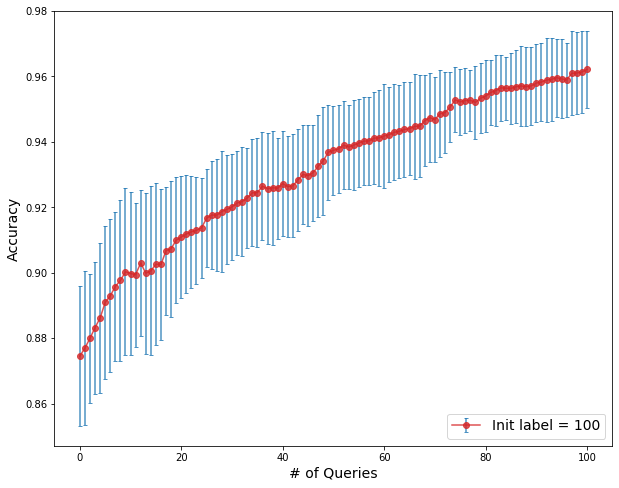

In [8]:
display(err, mean)